In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import math
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.utils import shuffle
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

np.random.seed(42)

In [2]:
iris_data = load_iris() 
x = iris_data.data
y_ = iris_data.target.reshape(-1, 1)

encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(y_)

#print(y)

# Split the data for training and testing
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.20)

/home/havish/.local/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [3]:
def relu(x):
    x[x<0]=0
    return x
def softmax(arr):
#     arr = arr/np.max(arr)
    return np.exp(arr)/(np.sum(np.exp(arr),axis=0))
def diff_relu(arr):
    z = np.zeros(arr.shape)
    z[arr<=0] = 0
    z[arr>0] = 1
    return z

In [4]:
def initializer(fan_out,fan_in):
    limit = np.sqrt(2*1.0/(fan_in+fan_out))
#     return np.random.uniform(-limit,limit,(fan_out,fan_in))
    return np.random.normal(0,limit,(fan_out,fan_in))

In [5]:
### architecture ###
in_dim = 4
hid1_dim = 10
hid2_dim = 10
out_dim = 3
W1 = initializer(hid1_dim,in_dim)
b1 = initializer(hid1_dim,1)
W2 = initializer(hid2_dim,hid1_dim)
b2 = initializer(hid2_dim,1)
W3 = initializer(out_dim,hid2_dim)
b3 = initializer(out_dim,1)

In [6]:
epochs = 500
num_samples = len(train_x)
batch_size = 10
delta_const = 1e-10
num_batches = num_samples/batch_size
eps = 1e-3
rho = 0.1
loss1 = []
r = {"W1" : np.zeros(W1.shape) , "W2" : np.zeros(W2.shape) ,"W3" : np.zeros(W3.shape),"b1": np.zeros(b1.shape)
     ,"b2" :np.zeros(b2.shape) , "b3" : np.zeros(b3.shape)}
for i in range(epochs):
    (x_train_subs,y_train_subs) = shuffle(train_x,train_y,random_state = 40)
    loss = 0
    for j in range(int(num_batches)):
        W1_upd = np.zeros((hid1_dim,in_dim))
        b1_upd = np.zeros((hid1_dim,1))
        W2_upd = np.zeros((hid2_dim,hid1_dim))
        b2_upd = np.zeros((hid2_dim,1))
        W3_upd = np.zeros((out_dim,hid2_dim))
        b3_upd = np.zeros((out_dim,1))
        for k in range(batch_size):
            x1 = np.matmul(W1,x_train_subs[j*batch_size+k]).reshape(-1,1)+b1
            z1 = relu(x1)
            
            x2 = np.matmul(W2,z1).reshape(-1,1)+b2
            z2 = relu(x2)

            out = softmax(np.matmul(W3,z2).reshape(-1,1) + b3)
        
            loss = loss + -np.log(out[np.argmax(y_train_subs[j*batch_size+k])])
        
            del_3 = out - y_train_subs[j*batch_size+k].reshape(-1,1)
            del_2 = np.matmul(W3.T,del_3)*diff_relu(x2)
            del_1 = np.matmul(W2.T,del_2)*diff_relu(x1)

            b3_upd += del_3
#         b3_upd = b3_upd.reshape(len(b3),1)
            b2_upd += del_2
#         b2_upd = b2_upd.reshape(len(b2),1)
            b1_upd += del_1
#         b1_upd = b1_upd.reshape(len(b1),1)
            W3_upd += np.matmul(del_3,z2.T)
            W2_upd += np.matmul(del_2,z1.T)
            W1_upd += np.matmul(del_1,x_train_subs[j*batch_size+k].reshape(-1,1).T)
        r["W1"] = (1-rho)*r["W1"] + rho*W1_upd*W1_upd
        r["W2"] = (1-rho)*r["W2"] + rho*W2_upd*W2_upd
        r["W3"] = (1-rho)*r["W3"] + rho*W3_upd*W3_upd
        r["b1"] = (1-rho)*r["b1"] + rho*b1_upd*b1_upd
        r["b2"] = (1-rho)*r["b2"] + rho*b2_upd*b2_upd
        r["b3"] = (1-rho)*r["b3"] + rho*b3_upd*b3_upd
        W3 = W3 - (eps*W3_upd)/np.sqrt(delta_const + r["W3"])
        W2 = W2 - (eps*W2_upd)/np.sqrt(delta_const + r["W2"])
        W1 = W1 - (eps*W1_upd)/np.sqrt(delta_const + r["W1"])
        b3 = b3 - (eps*b3_upd)/np.sqrt(delta_const + r["b3"])
        b2 = b2 - (eps*b2_upd)/np.sqrt(delta_const + r["b2"])
        b1 = b1 - (eps*b1_upd)/np.sqrt(delta_const + r["b1"])
    loss1.append(loss)
    print("Epoch: " + str(i) + " Loss: " + str(loss))

Epoch: 0 Loss: [238.09232098]
Epoch: 1 Loss: [207.19354434]
Epoch: 2 Loss: [178.55530454]
Epoch: 3 Loss: [155.10951554]
Epoch: 4 Loss: [134.1552848]
Epoch: 5 Loss: [115.80221066]
Epoch: 6 Loss: [99.11284279]
Epoch: 7 Loss: [84.01449088]
Epoch: 8 Loss: [73.15397335]
Epoch: 9 Loss: [65.53428186]
Epoch: 10 Loss: [60.03745119]
Epoch: 11 Loss: [55.99601421]
Epoch: 12 Loss: [52.93065498]
Epoch: 13 Loss: [50.5150736]
Epoch: 14 Loss: [48.43249139]
Epoch: 15 Loss: [46.54743032]
Epoch: 16 Loss: [44.66239883]
Epoch: 17 Loss: [42.95403036]
Epoch: 18 Loss: [41.21936426]
Epoch: 19 Loss: [39.5971054]
Epoch: 20 Loss: [38.14815106]
Epoch: 21 Loss: [36.83156993]
Epoch: 22 Loss: [35.60288605]
Epoch: 23 Loss: [34.45208605]
Epoch: 24 Loss: [33.37243148]
Epoch: 25 Loss: [32.33079285]
Epoch: 26 Loss: [31.33709786]
Epoch: 27 Loss: [30.38594404]
Epoch: 28 Loss: [29.47792922]
Epoch: 29 Loss: [28.61472265]
Epoch: 30 Loss: [27.77812157]
Epoch: 31 Loss: [26.97052277]
Epoch: 32 Loss: [26.19576709]
Epoch: 33 Loss: [

Epoch: 274 Loss: [7.87752337]
Epoch: 275 Loss: [7.87296101]
Epoch: 276 Loss: [7.86845546]
Epoch: 277 Loss: [7.86400147]
Epoch: 278 Loss: [7.8599247]
Epoch: 279 Loss: [7.85407625]
Epoch: 280 Loss: [7.85268903]
Epoch: 281 Loss: [7.84832158]
Epoch: 282 Loss: [7.84435327]
Epoch: 283 Loss: [7.83985617]
Epoch: 284 Loss: [7.83549622]
Epoch: 285 Loss: [7.83118962]
Epoch: 286 Loss: [7.82693004]
Epoch: 287 Loss: [7.82319208]
Epoch: 288 Loss: [7.81754068]
Epoch: 289 Loss: [7.81635819]
Epoch: 290 Loss: [7.81216094]
Epoch: 291 Loss: [7.80780385]
Epoch: 292 Loss: [7.80402543]
Epoch: 293 Loss: [7.79975975]
Epoch: 294 Loss: [7.79562654]
Epoch: 295 Loss: [7.79154047]
Epoch: 296 Loss: [7.78789384]
Epoch: 297 Loss: [7.78269458]
Epoch: 298 Loss: [7.78167576]
Epoch: 299 Loss: [7.77765674]
Epoch: 300 Loss: [7.77343632]
Epoch: 301 Loss: [7.76925709]
Epoch: 302 Loss: [7.76567184]
Epoch: 303 Loss: [7.76161991]
Epoch: 304 Loss: [7.75769044]
Epoch: 305 Loss: [7.75380302]
Epoch: 306 Loss: [7.7519707]
Epoch: 307 L

In [7]:
z1 = relu(np.matmul(W1,test_x[4]).reshape(-1,1)+b1)
z2 = relu(np.matmul(W2,z1).reshape(-1,1)+b2)
out = softmax(np.matmul(W3,z2).reshape(-1,1) + b3)

In [8]:
print(out)

[[1.92912534e-11]
 [9.98196417e-01]
 [1.80358319e-03]]


In [9]:
print(test_y[4])

[0. 1. 0.]


In [10]:
preds = []
true = []
# print(np.argmax(out))
for i in range(len(test_x)):
    z1 = relu(np.matmul(W1,test_x[i]).reshape(-1,1)+b1)
    z2 = relu(np.matmul(W2,z1).reshape(-1,1)+b2)
    out = softmax(np.matmul(W3,z2).reshape(-1,1) + b3)
    preds.append(np.argmax(out))
    true.append(np.argmax(test_y[i]))

In [11]:
print(preds)

[1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0]


In [12]:
print(true)

[1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0]


In [13]:
acc =accuracy_score(y_pred=preds,y_true=true)
print(acc)

1.0


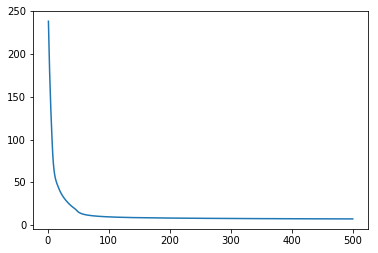

In [14]:
epochs = np.arange(1,501)
plt.plot(epochs,loss1)
plt.show()

In [15]:
for elem in np.array(loss1):
    print(str(elem[0])+',' , end = '')

238.09232098132347,207.1935443392004,178.5553045369865,155.1095155440195,134.15528479780264,115.80221065814715,99.11284279085812,84.01449087976515,73.153973346641,65.53428185840983,60.0374511899548,55.996014206239906,52.93065497828168,50.51507360112955,48.43249138583043,46.54743032429699,44.66239882583107,42.95403035931178,41.2193642572531,39.59710540250523,38.14815106307132,36.831569927156956,35.602886047407566,34.4520860483485,33.37243148097362,32.33079285344525,31.337097862035016,30.385944037980803,29.477929222529305,28.614722653942607,27.778121573899934,26.9705227666933,26.19576709369456,25.45200422105666,24.735696547355886,24.042535903906273,23.387993281606512,22.755598118914467,22.146038639317382,21.55716056771085,20.993967545768623,20.45432789743822,19.927562376783335,19.394550101652992,18.824431419792237,18.183765017025344,17.423715166132787,16.65244725437301,15.990246086522127,15.415760974707727,14.902791909948636,14.477217834183369,14.102127326566631,13.778964790232385,13.492